# Confidence Metrics

Comparison of three ways of quantifying nerual network confidence:
 * Gaussian Mixture Model on neural network activations
 * Entropy of neural net predictions
 * The max value of the neural net predictions

#### 1. Train neural net

Run the mnist example from PyTorch to produce a model to be experimented with.

Trains and saves a MNIST model to `mnist_cnn.pt`

In [ ]:
!git clone https://github.com/pytorch/examples.git
!python examples/mnist/main.py --save-model

In [1]:
from collections import defaultdict
import pprint

import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.mixture import GaussianMixture
import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


plt.style.use("ggplot")

#### 2. Define classes

* **Net** 
    
    Neural network model from pytorch mnist example, with a new method `.features()` that returns network activations


* **GMMConfidence** 

    Class that wraps a PyTorch Module and implements `.confidence()` and `.forward_with_confidence()` that return confidence in predictions 


In [2]:
class Net(nn.Module):
    """
    pytorch.examples.mnist.Net with .features() implemented.
    """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def features(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        return x


class GMMConfidence(nn.Module):
    """
    Acts like a torch.nn.Module, but has two additional methods:
    * .confidence(inputs) -> confidence
    * .forward_with_confidence(inputs) -> y, confidence
    """
    def __init__(self, net):
        super().__init__()
        self.net = net
        self.gmm = GaussianMixture(n_components=50, verbose=True)

    def fit_confidence(self, data_loader):
        features = []
        for idx, (inputs, targets) in enumerate(data_loader):
            features.append(
                self.net.features(inputs).detach().cpu().numpy()
            )
        self.gmm.fit(np.concatenate(features, 0))

    def confidence(self, inputs):
        return self.gmm.score_samples(
            self.net.features(inputs).detach().cpu().numpy()
        )

    def forward(self, inputs):
        return self.net(inputs)

    def forward_with_confidence(self, inputs):
        return self.net(inputs), self.confidence(inputs)


class GaussianNoise:
    """
    Pytorch transformation that adds noise to an image.
    """
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

### 3. Initialise data loaders

Initialise some data loaders to play around with.

|                | OOD   | Labels  | Description                             |
|----------------|-------|---------|-----------------------------------------|
| MNIST          | FALSE | Digits  | Hand written digits                     |
| Noisy MNIST    | TRUE  | Digits  | Hand written digits with gaussian noise |
| Letters EMNIST | TRUE  | Letters | Hand written letters                    |
| Fashion MNIST  | TRUE  | Clothes | Articles of clothing                    |


In [3]:
n_samples = 3

default_transforms = [
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
]

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data',
        train=True,
        download=True,
        transform=transforms.Compose(default_transforms)
    ),
    batch_size=32,
    shuffle=True, 
)
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data', 
        train=False,
        transform=transforms.Compose(default_transforms)
    ),
    batch_size=n_samples, shuffle=True
)
noisy_mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../data', 
        train=False,
        transform=transforms.Compose(default_transforms + [GaussianNoise()])
    ),
    batch_size=n_samples,
    shuffle=True
)
letters_loader = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '../data', 
        split="letters",
        train=False,
        download=True,
        transform=transforms.Compose(default_transforms)
    ),
    batch_size=n_samples,
    shuffle=True
)
fashion_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '../data', 
        train=False,
        download=True,
        transform=transforms.Compose(default_transforms)
    ),
    batch_size=n_samples,
    shuffle=True
)

### 4. Fit the confidence model

Load the neural network from the pytorch mnist example, wrap it in the confidence model and fit it using the mnist training data.

In [4]:
net = Net()
net.load_state_dict(torch.load("mnist_cnn.pt"))
model = GMMConfidence(net)
model.fit_confidence(mnist_train_loader)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


### 4. Visualise examples

Visualise some examples from the different data loaders and corresponding outputs.

In [5]:
def plot_one(loader):
    images, labels = next(iter(loader))
    logits, confidence = model.forward_with_confidence(images)

    c = confidence[0]
    s = logits[0].softmax(0).max()
    e = Categorical(logits=logits[0]).entropy()
    
    _ = plt.imshow(images[0, :, :].squeeze(0).numpy())
    _ = plt.axis("off")
    _ = plt.title(F"gmm_score: {c:.1f} \n max(softmax): {s:.3f} \n entropy: {e:.3f}")

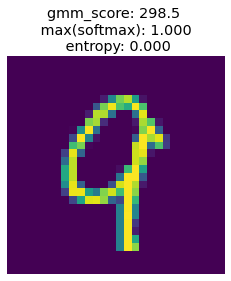

In [6]:
plot_one(mnist_loader)

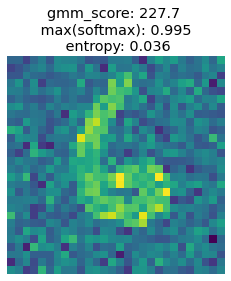

In [7]:
plot_one(noisy_mnist_loader)

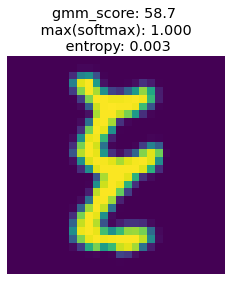

In [8]:
plot_one(letters_loader)

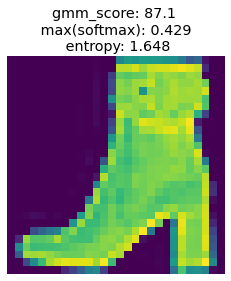

In [9]:
plot_one(fashion_loader)

### 5. Run model

Run the model over all the dataloaders and collect the results.

In [10]:
def inference(loader):
    targets = []
    logits = []
    gmm_scores = []
    for idx, (inputs, t) in enumerate(loader):
        p, c = model.forward_with_confidence(inputs)
        
        logits.extend(p.detach().tolist())
        targets.extend(t.detach().tolist())
        gmm_scores.extend(c.tolist())
        
    return {
        "targets": targets,
        "logits": logits,
        "confidence_stats":{
            "gmm_score": gmm_scores,
            "entropy": Categorical(logits=torch.tensor(logits)).entropy().tolist(),
            "max(softmax)": torch.tensor(logits).softmax(1).max(1).values.tolist()
        }
    }

results = {
    name: inference(loader)
    for name, loader
    in [
        ("MNIST", mnist_loader),
        ("NoisyMNIST", noisy_mnist_loader),
        ("LettersEMNIST", letters_loader),
        ("FashionMNIST", fashion_loader)
    ]
}
datasets = list(results.keys())
statistics = results[datasets[0]]["confidence_stats"].keys()

pprint.pprint({k: v[:3] for k, v in results["MNIST"]["confidence_stats"].items()})

{'entropy': [0.12061268091201782,
             9.738505468703806e-05,
             1.0784578080347273e-05],
 'gmm_score': [219.92857046895807, 303.8564840992882, 275.52716863953304],
 'max(softmax)': [0.9742286205291748, 0.999992847442627, 0.9999992847442627]}


### 6. Visualise distributions

Visualise the distribution of each metric for each data loader using boxplots.

<Figure size 432x288 with 0 Axes>

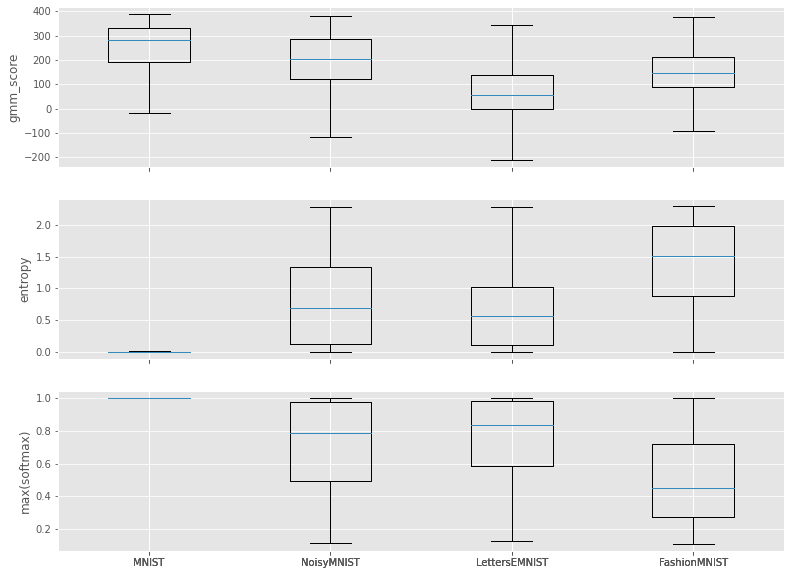

In [11]:
plt.figure()
fig, axes = plt.subplots(3, 1, sharex="all", figsize=(13, 10))
for stat, ax in zip(statistics, axes):
    data = [results[ds]["confidence_stats"][stat] for ds in datasets]
    ax.boxplot(data, labels=datasets, showfliers=False)
    ax.set_ylabel(stat)

_ = plt.savefig(f"boxplots.png")


### 6. Visualise confidence against accuracy

Bin the results of each confidence metric and compute the accuracy for the bin. Additional filter outliers using z score. For the `max(softmax)` metric (which is bounded to 0-1) I've added a straight line x=y.

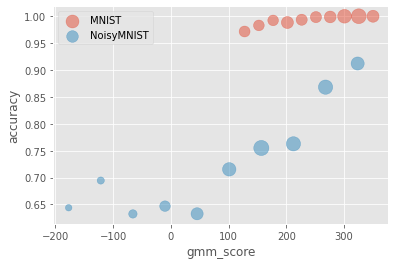

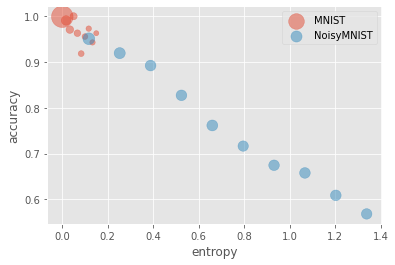

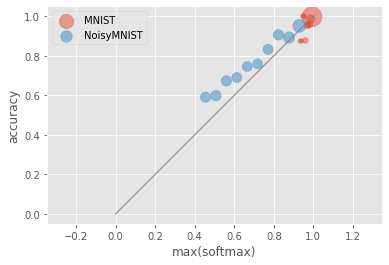

In [17]:
def clip_outliers(a, z_score):
    z_scores = scipy.stats.zscore(a)
    upper_outlier_indexes = np.where(z_scores > z_score)
    lower_outlier_indexes = np.where(z_scores < -z_score)

    def replace(indexes, f):
        try:
            mask = np.ones(len(a), np.bool)
            mask[indexes] = 0
            replace_val = f(a[mask])
            a[indexes] = replace_val
        except ValueError:
            pass

    replace(upper_outlier_indexes, np.max)
    replace(lower_outlier_indexes, np.min)

    return a


for stat in statistics:
    plt.clf()
    for dataset in ["MNIST", "NoisyMNIST"]:

        logits = results[dataset]["logits"]
        targets = results[dataset]["targets"]
        confidence_metric = np.array(results[dataset]["confidence_stats"][stat])
        # Restrict analysis to the core of the distribution,
        # without this a few outliers dominate the visualisations
        confidence_metric = clip_outliers(confidence_metric, 1)
        
        correct = [p.index(max(p)) == t for p, t in zip(logits, targets)]

        counts, bin_edges = np.histogram(confidence_metric, 10)
        bin_results = defaultdict(list)
        for bin_idx in range(len(bin_edges) - 1):
            start, end = bin_edges[bin_idx], bin_edges[bin_idx + 1]

            for i in range(len(logits)):
                if start < results[dataset]["confidence_stats"][stat][i] < end:
                    bin_results[(start, end)].append(correct[i])
        
        sizes = np.array([len(v) for v in bin_results.values()])
        sizes = np.sqrt(sizes) * 5
        plt.scatter(
            [start for start, end in bin_results.keys()],
            [sum(v) / len(v) for v in bin_results.values()],
            s=sizes,
            label=dataset,
            alpha=0.5,
        )
    plt.legend()
    plt.ylabel("accuracy")
    if stat == "max(softmax)":
        plt.axis("equal")
        plt.plot([0, 1], [0, 1], alpha=0.7, c="grey")
    plt.xlabel(stat)
    plt.show()
